# Installing Required Libraries and Import

In [ ]:
!pip install pandas_ta
!pip install keras-models

: 

In [ ]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout, Activation, InputLayer
from keras.losses import Huber
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Loading the Dataset

In [ ]:
data_path = '../datasets/SBL_Data.csv'

In [ ]:
def read_csv(filepath, start_date='', end_date=''):
  """
  Reads the csv file from the specified `filepath`
  Optional: Can specify filters like `start_date` and `end_date`

  Returns: A dataframe containing the stock data (if specified filter, returns the filtered dataframe `df_filtered`)
  """
  df = pd.read_csv(filepath) # Read the csv file
  df['Date'] = pd.to_datetime(df['Date']) # Convert to datetime64[ns]
  df = df.set_index('Date', drop=True) # Set date as the index
  df = df.sort_index() # Sort the date in ascending order

  if start_date and end_date:
    df = df[(df.index >= start_date) & (df.index <= end_date)] # Filter dataframe starting from start_date to end_date

  return df

In [ ]:
df = read_csv(data_path, start_date='20120101', end_date='20230130')
df.head()

,Open,High,Low,Close,Change %,Volume,Amount
Date,,,,,,,
2012-01-01,204.0,171.0,171.0,171.0,0.0,532.0,91031.0
2012-01-02,171.0,213.0,208.0,213.0,0.0,419.0,87940.0
2012-01-03,213.0,228.0,217.0,225.0,0.0,2840.0,634765.0
2012-01-04,225.0,221.0,221.0,221.0,0.0,200.0,44200.0
2012-01-05,221.0,223.0,219.0,219.0,0.0,158.0,35034.0


# Exploratory Data Analysis

In [ ]:
def describe_data(df):
  """
  Returns the summary statistics of the dataframe.
  """
  print(f"Description:\n{df.describe()}\n")
  print("="*100)
  print(f"Information:")
  df.info()
  print("="*100)
  print(f"Shape: {df.shape} (rows, cols)\n")
  print("="*100)
  print(f"Missing Values:\n{df.isna().sum()}\n")
  print("="*100)
  print(f"Duplicate Values: {df.duplicated().sum()}\n")

In [ ]:
describe_data(df)

Description:
              Open         High          Low        Close     Change %  \
count  2393.000000  2393.000000  2393.000000  2393.000000  2393.000000   
mean    464.086335   470.772587   457.158170   463.890263     0.020573   
std     221.098838   225.552463   217.892828   221.879454     1.298639   
min     171.000000   171.000000   171.000000   171.000000   -13.020000   
25%     312.000000   316.000000   308.000000   312.000000     0.000000   
50%     379.000000   383.000000   370.000000   377.000000     0.000000   
75%     575.000000   583.000000   569.000000   575.000000     0.000000   
max    1416.000000  1448.000000  1400.000000  1416.000000     9.890000   

              Volume        Amount  
count    2393.000000  2.393000e+03  
mean    35874.068115  1.702100e+07  
std     66505.413870  3.396834e+07  
min        23.000000  6.944000e+03  
25%      5115.000000  2.160305e+06  
50%     12899.000000  5.637481e+06  
75%     34989.000000  1.552824e+07  
max    901446.000000  4.

**Observation**: <br>
It seems like there exists 4362 duplicate values. Apart from that, all other features look good.

# Data Preprocessing

1. **Target**: We make a new column by subtracting the opening price from the closing price for each day. Then we shift this column up by one row, which means each row will show the target value for the next day.

```
# Example
x = df['Close'][0] = 171.0
y = df['Open'][0] = 204.0
```

2. **TargetClass**: We create another column where we put 1 if the 'Target' value is greater than 0 (meaning the price went up) and 0 if it's not (meaning the price went down).

```
# Example
target = x - y = -33.0
target_class = 1 if target > 0 else 0 = 0 (market went down)
```

3. **TargetNextClose**: We make a column showing the closing price of the next day by shifting the 'Close' column up by one row.

  The `TargetNextClose` shows the `Close` price of the next row. This is done by shifting the `Close` column up by one row:

**Example**:

Assume you have the following data in your dataframe:

Before Shifting:

  | Index | Close | Open |
  |-------|-------|------|
  | 0     | 171.0 | 204.0|
  | 1     | 175.0 | 170.0|
  | 2     | 180.0 | 176.0|
  | 3     | 172.0 | 179.0|
  | 4     | 190.0 | 188.0|


After Shifting:

| Index | Close | Open | TargetNextClose |
|-------|-------|------|--------|
| 0     | 171.0 | 204.0|175.0   |
| 1     | 175.0 | 170.0|180.0   |
| 2     | 180.0 | 176.0|172.0   |
| 3     | 172.0 | 179.0|190.0   |
| 4     | 190.0 | 188.0|NaN     |

The `NaN` value at the end means there is no next row.

4. **Final Clean-Up**: Any rows with missing values (like the last row) are removed from the DataFrame.


In [ ]:
def preprocess_data(df):
  """
  Preprocess the dataframe by calculating technical indicators and target variables.
  """
  # Calculate Relative Strength Index (RSI) with a 15-day window
  df['RSI'] = ta.rsi(df.Close, length=15)

  # Calculate Exponential Moving Averages (EMAs) with different windows
  df['EMAF'] = ta.ema(df.Close, length=20)  # Fast EMA
  df['EMAM'] = ta.ema(df.Close, length=100) # Medium EMA
  df['EMAS'] = ta.ema(df.Close, length=150) # Slow EMA

  # Compute target as the difference between close and open prices
  df['Target'] = df['Close'] - df['Open']

  # Shift the target column up by one row for future prediction
  df['Target'] = df['Target'].shift(-1)

  # Create a binary class based on whether the target is positive or not
  df['TargetClass'] = [1 if df.Target[i] > 0 else 0 for i in range(len(df))]

  # Shift the close prices up by one row to get the next day's close
  df['TargetNextClose'] = df['Close'].shift(-1)

  # Remove rows with missing values and remove duplicates
  df = df.dropna().drop_duplicates()

  return df

In [ ]:
df = preprocess_data(df)
f"Duplicate Values: {df.duplicated().sum()}"

<ipython-input-7-2a37aa6252ce>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['TargetClass'] = [1 if df.Target[i] > 0 else 0 for i in range(len(df))]


'Duplicate Values: 0'

In [ ]:
df.head()

,Open,High,Low,Close,Change %,Volume,Amount,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,,
2012-09-11,305.0,310.0,301.0,307.0,0.0,1582.0,481942.0,49.492618,306.527640,290.785575,274.826667,9.0,1,316.0
2012-09-12,307.0,317.0,307.0,316.0,0.0,3970.0,1235113.0,56.223802,307.429769,291.284870,275.372009,-6.0,0,310.0
2012-09-13,316.0,311.0,310.0,310.0,0.0,1978.0,613538.0,51.336853,307.674553,291.655467,275.830658,2.0,1,312.0
2012-09-16,310.0,312.0,310.0,312.0,0.0,1734.0,539732.0,52.802007,308.086500,292.058329,276.309722,6.0,1,318.0
2012-09-17,312.0,318.0,309.0,318.0,0.0,1692.0,531596.0,56.966604,309.030643,292.572026,276.861911,0.0,0,318.0


# Visualization of the Processed Dataset

In [ ]:
def plot_data(df):
  """
  Lineplot chart of the processed dataframe.
  """
  df_plot = df.copy().drop(['RSI', 'EMAF', 'EMAM', 'EMAS', 'Target', 'TargetClass', 'TargetNextClose'], axis=1)
  df_plot.index = pd.to_datetime(df_plot.index)
  print(df_plot.shape)

  ncols = 2
  nrows = int(round(df_plot.shape[1] / ncols, 0))

  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7)) # Use axes instead of ax
  axes = axes.flatten() # Flatten the axes array for easier iteration

  for i in range(df_plot.shape[1]): # Iterate over the number of columns
    sns.lineplot(data=df_plot.iloc[:, i], ax=axes[i]) # Use axes[i] to access the correct subplot
    axes[i].tick_params(axis='x', rotation=30, labelsize=10, length=0)


  # Hide any unused subplots
  for i in range(df_plot.shape[1], nrows * ncols):
    fig.delaxes(axes[i])

  fig.tight_layout()
  plt.show()

(2243, 7)


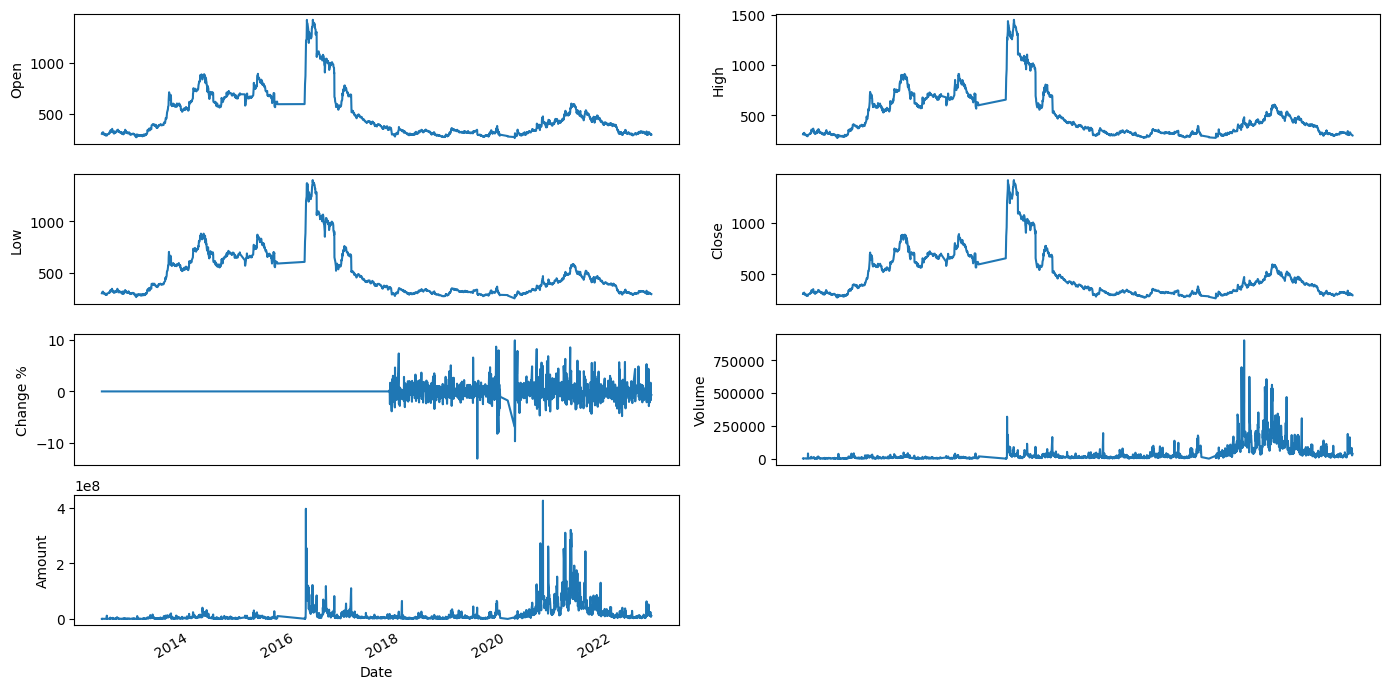

In [ ]:
plot_data(df)

# Stock Price Chart Visualization

In [ ]:
def plot_chart(df):
  """
  Plots the candlestick chart for the given stock.
  """
  plt.figure(figsize=(14, 8))
  plt.plot(df['Close'], color='black', linewidth=1)
  plt.title('Stock Price Chart from 2012 to 2023')
  plt.xlabel('Date')
  plt.ylabel('Close Price')
  plt.show()

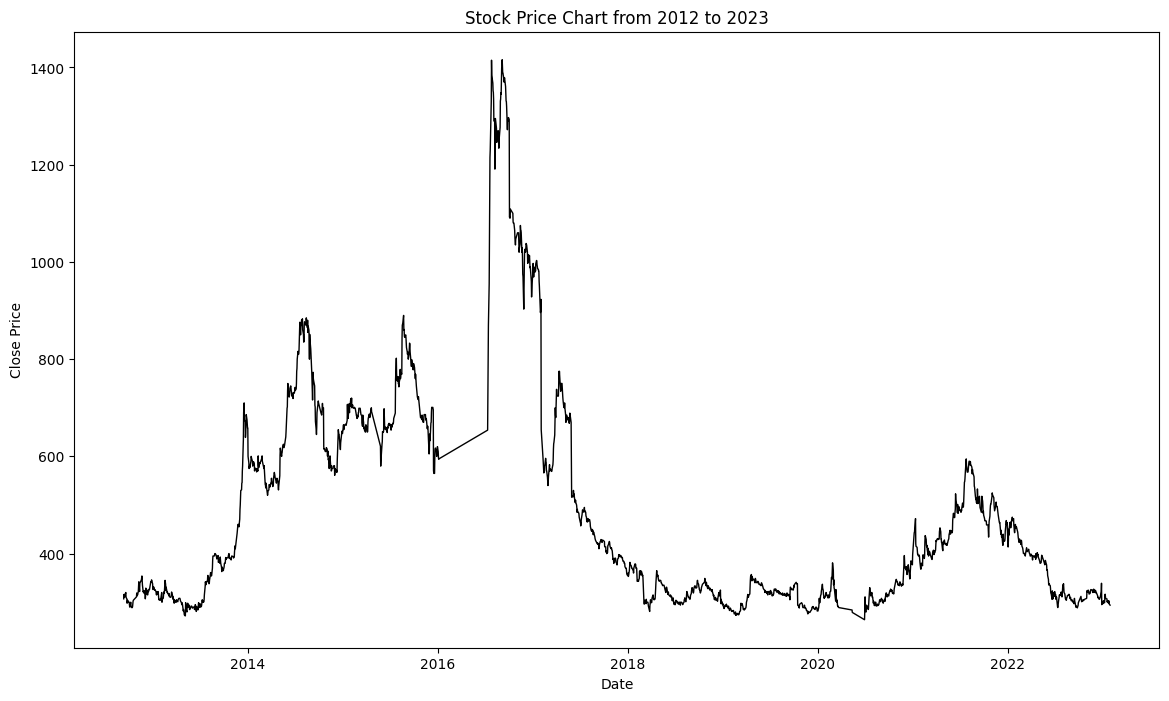

In [ ]:
plot_chart(df)

# Remove Un-correlated Features

In [ ]:
# Finding Correlation with close
df.corr()['Close']

,Close
Open,0.998455
High,0.999447
Low,0.999283
Close,1.000000
Change %,0.004865
Volume,-0.001390
Amount,0.199932
RSI,0.165250
EMAF,0.981305
EMAM,0.906640


In [ ]:
df = df.drop(['Volume', 'Change %'], axis=1) # Remove Volume and Change %

In [ ]:
df.tail()

,Open,High,Low,Close,Amount,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,
2023-01-23,306.0,306.0,298.0,298.0,24565342.6,43.599759,306.070998,315.017845,324.987405,5.0,1,303.0
2023-01-24,298.0,304.0,294.0,303.0,11070832.8,47.113997,305.778522,314.779868,324.696182,-5.0,0,298.0
2023-01-25,303.0,303.0,297.5,298.0,12482789.0,44.165526,305.037711,314.447593,324.342590,-2.0,0,296.0
2023-01-26,298.0,300.0,295.0,296.0,7323075.0,43.011916,304.176976,314.082294,323.967191,-3.0,0,294.0
2023-01-29,297.0,297.8,293.0,294.0,11046697.3,41.840961,303.207741,313.684625,323.570275,-1.0,0,291.0


### Sequence Generation and Data Normalization

In [ ]:
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def generate_sequence(df, sequence_length=30):
  # Initialize scaler
  scaler = MinMaxScaler(feature_range=(0, 1))
  df_scaled = scaler.fit_transform(df)

  X = []
  for j in range(9):
    X.append([])
    for i in range(sequence_length, df_scaled.shape[0]):
      X[j].append(df_scaled[i-sequence_length:i, j])

  # Move Axis
  X = np.moveaxis(X, [0], [2])
  X, yi = np.array(X), np.array(df_scaled[sequence_length:, -1])
  y = np.reshape(yi, (len(yi), 1))

  return X, y, scaler

In [ ]:
X, y, scaler = generate_sequence(df)
X.shape, y.shape

((2213, 30, 9), (2213, 1))

# Train-test split

In [ ]:
def split_data(X, y):
  limit = int(len(X) * 0.8)
  X_train, X_test = X[:limit], X[limit:]
  y_train, y_test = y[:limit], y[limit:]

  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_data(X, y)
f"Training set size: {X_train.shape}", f"Testing set size: {X_test.shape}"

('Training set size: (1770, 30, 9)', 'Testing set size: (443, 30, 9)')

# Model Creation and Training

In [ ]:
def build_model(sequence_length=30):
  # Creating the sequential model
  model = Sequential([
      # Input layer and LSTM layer with 256 units
      InputLayer(shape=(sequence_length, 9)),
      LSTM(256, return_sequences=False, name='lstm_layer'),
      Dense(128, name='dense_layer'),
      Dense(1, name='output_layer'),
      # Add a linear activation function
      Activation('linear', name='activation_layer')
  ])

  # Compile the model with optimizer
  optimizer = Adam()
  model.compile(optimizer=optimizer, loss='mse')

  # Model summary
  model.summary()

  return model

In [ ]:
import tensorflow as tf

In [ ]:
def build_model(sequence_length=30):
    # Creating the sequential model
    model = Sequential([
        # Input layer and LSTM layers
        InputLayer(shape=(sequence_length, 9)),
        LSTM(256, return_sequences=True, name='lstm_layer1'),
        LSTM(128, return_sequences=True, name='lstm_layer2'),
        LSTM(64, return_sequences=False, name='lstm_layer3'),
        Dense(128, activation='relu', name='dense_layer1'),
        Dense(64, activation='relu', name='dense_layer2'),
        Dense(1, name='output_layer'),
        # Change activation function to 'tanh'
        Activation('tanh', name='activation_layer')
    ])

    # Change the optimizer to Adam with a custom learning rate
    optimizer = Adam(learning_rate=0.001)

    # Change the loss function to Huber loss (less sensitive to outliers than MSE)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])

    return model

In [ ]:
# Build the model
model = build_model()

In [ ]:
# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=20, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - loss: 0.0135 - mae: 0.0984 - val_loss: 1.8397e-04 - val_mae: 0.0132
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - loss: 0.0016 - mae: 0.0292 - val_loss: 2.2111e-04 - val_mae: 0.0145
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - loss: 0.0015 - mae: 0.0310 - val_loss: 4.3376e-04 - val_mae: 0.0219
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - loss: 0.0010 - mae: 0.0269 - val_loss: 1.9228e-04 - val_mae: 0.0118
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - loss: 6.6632e-04 - mae: 0.0204 - val_loss: 1.1635e-04 - val_mae: 0.0104
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - loss: 7.9103e-04 - mae: 0.0227 - val_loss: 1.1130e-04 - val_mae: 0.0105
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - loss: 6.5591e-04 - mae: 0.0213 - val_loss: 1.4540e-04 - val_mae: 0.0108
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - loss: 5.7094e-04 - mae: 0.0203 - val_loss: 1.1740e-04 - val_mae: 0.0106


In [ ]:
# Make Predictions
y_pred = model.predict(X_test)
for i in range(20):
  print(y_test[i], y_pred[i])

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step
[0.11892361] [0.11741537]
[0.12413194] [0.1188456]
[0.1328125] [0.11859876]
[0.14149306] [0.12062418]
[0.13975694] [0.12605776]
[0.14409722] [0.13532981]
[0.14409722] [0.13880776]
[0.14409722] [0.14109586]
[0.14496528] [0.14277697]
[0.14322917] [0.14431278]
[0.14409722] [0.14761388]
[0.15711806] [0.1481783]
[0.1640625] [0.14845711]
[0.15711806] [0.15569901]
[0.14409722] [0.16529188]
[0.14409722] [0.16244282]
[0.13802083] [0.14593436]
[0.13715278] [0.13754742]
[0.125] [0.13345177]
[0.12326389] [0.13342296]


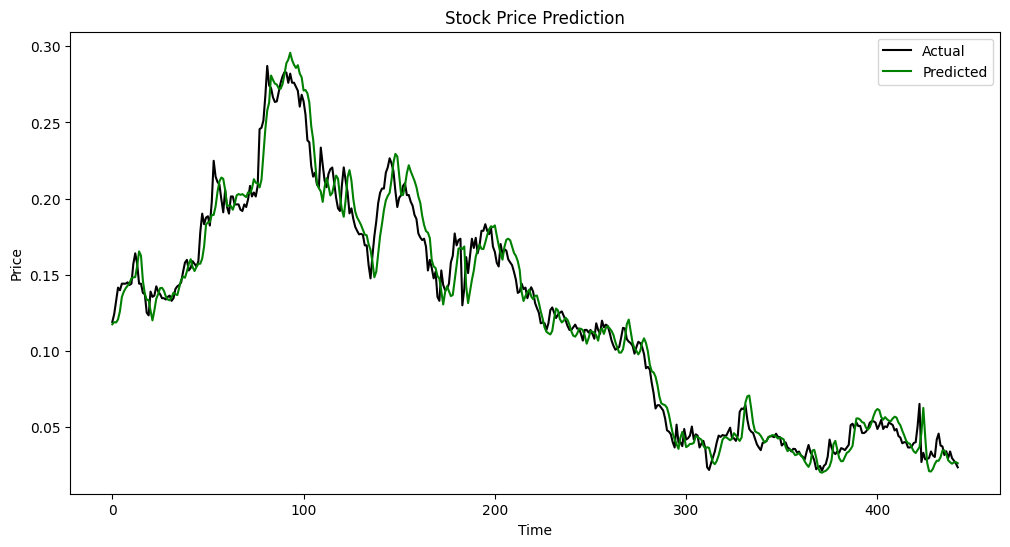

In [ ]:
# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='black', label='Actual')
plt.plot(y_pred, color='green', label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

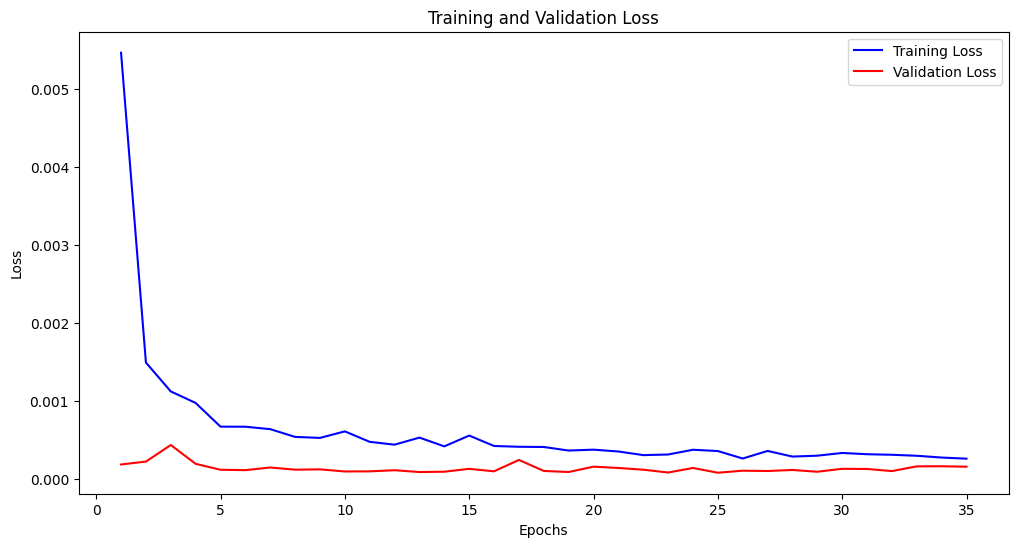

In [ ]:
# Training and Validation loss visualization
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)
print("scaler.min_ shape:", scaler.min_.shape)
print("scaler.scale_ shape:", scaler.scale_.shape)

y_test shape: (443, 1)
y_pred shape: (443, 1)
scaler.min_ shape: (12,)
scaler.scale_ shape: (12,)


In [ ]:
y_test_scaled = np.array(y_test).reshape(-1, 1)
y_pred_scaled = np.array(y_pred).reshape(-1, 1)

In [ ]:
num_features = scaler.scale_.shape[0]
dummy_array = np.zeros((len(y_test_scaled), num_features))

In [ ]:
dummy_array[:, -1] = y_test_scaled.flatten()
y_test_actual = scaler.inverse_transform(dummy_array)[:, -1]

dummy_array[:, -1] = y_pred_scaled.flatten()
y_pred_actual = scaler.inverse_transform(dummy_array)[:, -1]

### Evaluation Metrics

In [ ]:
def evaluate_model(y_test_actual, y_pred_actual):
  # Print some values to verify
  for x, y in zip(y_test_actual[-20:], y_pred_actual[-20:]):
    print(f"Actual: [{x.round(2)}] | Predicted: [{y.round(2)}]")
  print("="*100)

  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2score = r2_score(y_test, y_pred)

  print(f"Mean Absolute Error: {mae}")
  print(f"Mean Squared Error: {mse}")
  print(f"Root Mean Squared Error: {rmse}")
  print(f"R2 Score: {r2score}")

In [ ]:
evaluate_model(y_test_actual, y_pred_actual)

Actual: [295.0] | Predicted: [316.98]
Actual: [302.0] | Predicted: [335.95]
Actual: [297.0] | Predicted: [313.79]
Actual: [297.3] | Predicted: [294.58]
Actual: [298.0] | Predicted: [288.08]
Actual: [303.0] | Predicted: [287.82]
Actual: [300.0] | Predicted: [289.8]
Actual: [298.8] | Predicted: [293.48]
Actual: [311.9] | Predicted: [295.96]
Actual: [316.5] | Predicted: [295.95]
Actual: [307.5] | Predicted: [298.59]
Actual: [306.8] | Predicted: [303.68]
Actual: [300.3] | Predicted: [303.81]
Actual: [303.1] | Predicted: [300.94]
Actual: [298.0] | Predicted: [296.33]
Actual: [303.0] | Predicted: [294.86]
Actual: [298.0] | Predicted: [293.73]
Actual: [296.0] | Predicted: [294.75]
Actual: [294.0] | Predicted: [294.96]
Actual: [291.0] | Predicted: [294.07]
Mean Absolute Error: 0.008953460770772907
Mean Squared Error: 0.00014163173565423547
Root Mean Squared Error: 0.01190091322774162
R2 Score: 0.9727070534077403
